In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import signal
from mi_estimators import *
import sklearn.preprocessing as sklp
from tqdm import trange
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")
print(dev)

cuda


In [2]:
class ConvolutionSampler(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv =  nn.Conv1d(2, 2, kernel_size=100, groups=2, bias=False, padding='same')
        
        t = torch.arange(0, 100)
        tau1 = 5
        tau2 = 15
        k1 = torch.flip(torch.exp(-t/tau1), dims=[-1])
        k2 = torch.flip(torch.exp(-t/tau2), dims=[-1])
        
        
        for param in self.conv.parameters():
            param.data = torch.stack((k1, k2)).unsqueeze(1)
            
        self.W = torch.nn.Parameter(torch.tensor([[1.0, 1.5], [1.3, 0.75]], requires_grad = True))

    def forward(self, x):
        y = self.conv(x).double()
        return y.squeeze(0).T.double() @ self.W.double()

In [3]:
def gen_sine_wave(t, A, w, phase, baseline, sigma):
    noise = np.random.normal(0, sigma, len(t))
    y = A*np.sin(w*t + phase) + noise + baseline
    return y

def gen_square_wave(t, A, w, phase, baseline, sigma):
    noise = np.random.normal(0, sigma, len(t))
    y = A*signal.square(w*t + phase) + baseline + noise
    return y

In [4]:
t = np.linspace(0, 20, 10000)
sine = gen_sine_wave(t, A=1, w=2*np.pi/2, phase=0, baseline=0, sigma=0.25)
square = gen_square_wave(t, A=1, w=2*np.pi/5, phase=np.pi/2, baseline=0, sigma=0.25)

square = torch.tensor(square)
sine = torch.tensor(sine)
inputs = torch.stack((square, sine))
inputs.unsqueeze(0).size()

torch.Size([1, 2, 10000])

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\conv.py:297: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ..\aten\src\ATen\native\Convolution.cpp:647.)
  return F.conv1d(input, weight, bias, self.stride,


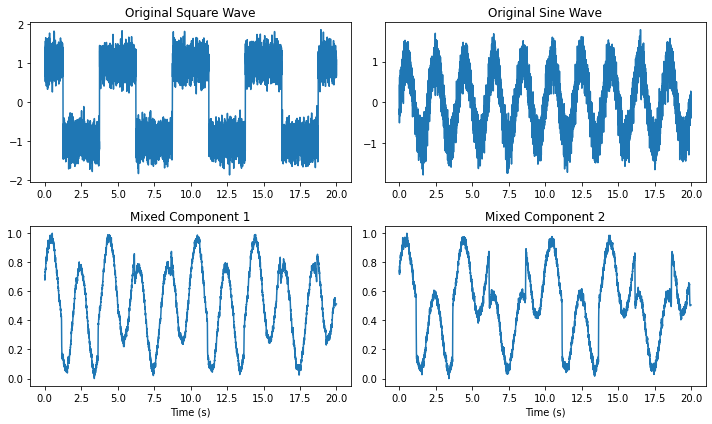

In [5]:
sampler = ConvolutionSampler()
y = sampler(inputs.unsqueeze(0).float())

plt.figure(figsize=(10,6))

plt.subplot(2, 2, 1)
plt.title('Original Square Wave')
plt.plot(t, inputs[0,:])

plt.subplot(2, 2, 2)
plt.title('Original Sine Wave')
plt.plot(t, inputs[1, :])

plt.subplot(2,2,3)
plt.title('Mixed Component 1')
plt.plot(t, sklp.minmax_scale(y[:, 0].detach().numpy()))
plt.xlabel('Time (s)')

plt.subplot(2,2,4)
plt.title('Mixed Component 2')
plt.plot(t, sklp.minmax_scale(y[:, 1].detach().numpy()))
plt.xlabel('Time (s)')

plt.tight_layout()
plt.savefig('time_dept_signal_convolutive_mixing2.jpeg')

In [75]:
class ConvolutiveDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv =  nn.Conv1d(2, 2, kernel_size=100, groups=2, bias=False, padding='same')
        
        #t = torch.arange(0, 100)
        #k1 = torch.flip(torch.exp(-t), dims=[-1])
        #k2 = torch.flip(torch.exp(-t), dims=[-1])
        
        
        for param in self.conv.parameters():
            param.data = torch.ones_like(param.data) * 0.01
        
        self.lin = nn.Linear(2, 2, bias=False)
        
    def forward(self, x_samples, y_samples):
        samples = torch.stack((x_samples, y_samples), dim=1)
        samples = samples.T.unsqueeze(0)
        samples_out = self.conv(samples)
        samples_out = samples_out.squeeze(0).T
        samples_out = self.lin(samples_out)
        return samples_out[:, 0], samples_out[:, 1]

In [7]:
def signal_clarity(sources, inputs):
    r = np.corrcoef(sources, inputs)
    c = np.absolute(np.diff(np.absolute(r), axis=0))
    return np.mean(c)

In [8]:
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().cpu())
            max_grads.append(p.grad.abs().max().cpu())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    

In [31]:
def train_model(data, lr, batch_size, num_epochs, num_mini_batches, schedule):

    sample_dim = 1
    hidden_size = 25

    decoder = ConvolutiveDecoder().to(dev)
    mi_estimator = CLUBSample(1, 1, hidden_size).to(dev)

    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr = lr)
    mi_optimizer = torch.optim.Adam(mi_estimator.parameters(), lr = lr)

    
    if schedule is True:
        decoder_scheduler = torch.optim.lr_scheduler.ExponentialLR(decoder_optimizer, gamma=0.999)
        mi_scheduler = torch.optim.lr_scheduler.ExponentialLR(mi_optimizer, gamma=0.999)

    mi_est_values = []
    clarity_est = []
    
    num_batches = len(data[:, 0]) // batch_size
    print('num:', num_batches)
    
    data_len = len(data[:, 0])

    
    x_samples = data[:, 0]
    y_samples = data[:, 1]
    for epoch in trange(num_epochs):

        random_indx = np.random.randint(num_batches, size=2)
        #random_indx = np.random.randint(data_len-batch_size, size=2)
        n = random_indx[0]
        m = random_indx[1]

        x_samples_out, y_samples_out = decoder(x_samples.float(), y_samples.float())
        x_samples_out = x_samples_out / torch.std(x_samples_out)
        y_samples_out = y_samples_out / torch.std(y_samples_out)

        x_samples_out = x_samples_out[n*batch_size : n*batch_size+batch_size]
        y_samples_out = y_samples_out[m*batch_size : m*batch_size+batch_size]
        #x_samples_out = x_samples_out[n : n + batch_size]
        #y_samples_out = y_samples_out[m : m + batch_size]

        decoder_loss = mi_estimator(x_samples_out.unsqueeze(0).T, y_samples_out.unsqueeze(0).T)
        decoder_optimizer.zero_grad()
        decoder_loss.backward(retain_graph=True)
        plot_grad_flow(decoder.named_parameters())
        decoder_optimizer.step()
        
        mi_est_values.append(decoder_loss.cpu().detach().numpy())
        #if np.absolute(decoder_loss.cpu().detach().numpy())<1e-12:
                #break
        
        for i in range(num_mini_batches):
            
            random_indx = np.random.randint(num_batches, size=2)
            #random_indx = np.random.randint(data_len-batch_size, size=2)
            n = random_indx[0]
            m = random_indx[1]

            x_samples_out, y_samples_out = decoder(x_samples.float(), y_samples.float())
            x_samples_out = x_samples_out / torch.std(x_samples_out)
            y_samples_out = y_samples_out / torch.std(y_samples_out)

            x_samples_out = x_samples_out[n*batch_size : n*batch_size+batch_size]
            y_samples_out = y_samples_out[m*batch_size : m*batch_size+batch_size]
            #x_samples_out = x_samples_out[n : n + batch_size]
            #y_samples_out = y_samples_out[m : m + batch_size]

            mi_loss = mi_estimator.learning_loss(x_samples_out.unsqueeze(0).T.detach(), y_samples_out.unsqueeze(0).T.detach())
            mi_optimizer.zero_grad()
            mi_loss.backward()
            mi_optimizer.step()
            
        if schedule is True: 
            #mi_scheduler.step()
            decoder_scheduler.step()
    
    
        x_samples, y_samples = decoder(data[:, 0].float(), data[:, 1].float())
        recovered = np.vstack((sklp.minmax_scale(x_samples.cpu().detach().numpy()), sklp.minmax_scale(y_samples.cpu().detach().numpy())))
        original = sklp.minmax_scale(inputs.T).T
        clarity_est.append(signal_clarity(original, recovered))

    return mi_est_values, clarity_est, x_samples.cpu().detach().numpy(), y_samples.cpu().detach().numpy(), decoder
    

num: 20


100%|██████████| 500/500 [29:01<00:00,  3.48s/it]


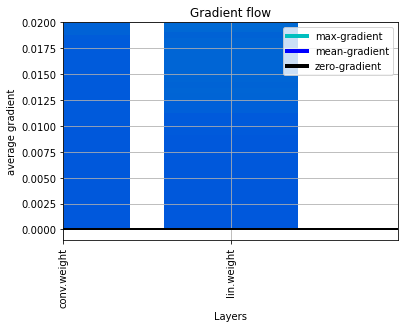

In [37]:
y = y.to(dev)
num_mini_batches = 2000
lr=1e-4
batch_size = 500 # equal to the length of the input
num_epochs = 500
schedule = False

mi_est_values, clarity_est, x_samples, y_samples, decoder = train_model(data=y, lr=lr, batch_size=batch_size, num_epochs=num_epochs, num_mini_batches=num_mini_batches, schedule=schedule)

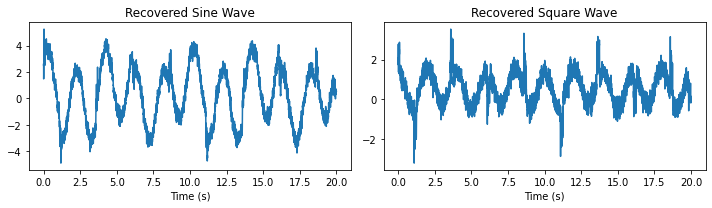

In [38]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.title('Recovered Sine Wave')
plt.plot(t, x_samples)

plt.xlabel('Time (s)')

plt.subplot(1, 2, 2)
plt.plot(t, y_samples)
plt.title('Recovered Square Wave')
plt.xlabel('Time (s)')

plt.tight_layout()
plt.savefig('recovered_components_convolution5.jpeg')

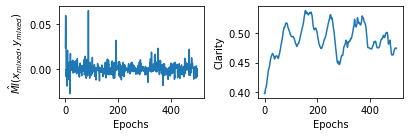

In [39]:
plt.figure(figsize=(6,2))
plt.subplot(1,2,1)
plt.plot(mi_est_values)
plt.xlabel('Epochs')
plt.ylabel('$\hat{MI}(x_{mixed}, y_{mixed})$')


plt.subplot(1,2,2)
plt.plot(clarity_est)
plt.xlabel('Epochs')
plt.ylabel('Clarity')
plt.tight_layout()
plt.savefig('MI_versus_epochs_timedept_convolution.jpeg')

## Test with multiple costs

In [39]:
def train_model_multi(data, lr, batch_size, num_epochs, num_mini_batches, M, schedule):
    sample_dim = 1
    hidden_size = 25

    decoder = ConvolutiveDecoder().to(dev)
    mi_estimator = CLUBSample(1, 1, hidden_size).to(dev)

    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr = lr)
    mi_optimizer = torch.optim.Adam(mi_estimator.parameters(), lr = lr)

    
    if schedule is True:
        decoder_scheduler = torch.optim.lr_scheduler.ExponentialLR(decoder_optimizer, gamma=0.999)
        mi_scheduler = torch.optim.lr_scheduler.ExponentialLR(mi_optimizer, gamma=0.999)

    mi_est_values = []
    clarity_est = []
    
    num_batches = len(data[:, 0]) // batch_size
    print('num:', num_batches)
    
    data_len = len(data[:, 0])

    
    x_samples = data[:, 0]
    y_samples = data[:, 1]
    
    x_samples = x_samples / torch.std(x_samples)
    y_samples = y_samples / torch.std(y_samples)
    for epoch in trange(num_epochs):

        random_indx = np.random.randint(num_batches, size=2)
        #random_indx = np.random.randint(data_len-batch_size, size=2)
        n = random_indx[0]
        m = random_indx[1]

        x_samples_out, y_samples_out = decoder(x_samples.float(), y_samples.float())
        x_samples_out = x_samples_out / torch.std(x_samples_out)
        y_samples_out = y_samples_out / torch.std(y_samples_out)

        x_samples_out_tmp = x_samples_out[n*batch_size : n*batch_size+batch_size]
        y_samples_out_tmp = y_samples_out[m*batch_size : m*batch_size+batch_size]
        #x_samples_out_tmp = x_samples_out[n : n + batch_size]
        #y_samples_out_tmp = y_samples_out[m : m + batch_size]

        decoder_loss = mi_estimator(x_samples_out_tmp.unsqueeze(0).T, y_samples_out_tmp.unsqueeze(0).T)
        
        for j in range(M):
            random_indx = np.random.randint(num_batches, size=2)
            #random_indx = np.random.randint(data_len-batch_size, size=2)
            n = random_indx[0]
            m = random_indx[1]
            x_samples_out_tmp = x_samples_out[n*batch_size : n*batch_size+batch_size]
            y_samples_out_tmp = y_samples_out[m*batch_size : m*batch_size+batch_size]
            #x_samples_out_tmp = x_samples_out[n : n + batch_size]
            #y_samples_out_tmp = y_samples_out[m : m + batch_size]
            decoder_loss += mi_estimator(x_samples_out_tmp.unsqueeze(0).T, y_samples_out_tmp.unsqueeze(0).T)
        
        decoder_optimizer.zero_grad()
        decoder_loss.backward(retain_graph=True)
        plot_grad_flow(decoder.named_parameters())
        decoder_optimizer.step()
        
        mi_est_values.append(decoder_loss.cpu().detach().numpy())
        
        if np.absolute(decoder_loss.cpu().detach().numpy())<1e-12 and epoch>10:
                break
        
        for i in range(num_mini_batches):
            
            random_indx = np.random.randint(num_batches, size=2)
            #random_indx = np.random.randint(data_len-batch_size, size=2)
            n = random_indx[0]
            m = random_indx[1]

            x_samples_out, y_samples_out = decoder(x_samples.float(), y_samples.float())
            x_samples_out = x_samples_out / torch.std(x_samples_out)
            y_samples_out = y_samples_out / torch.std(y_samples_out)

            x_samples_out_tmp = x_samples_out[n*batch_size : n*batch_size+batch_size]
            y_samples_out_tmp = y_samples_out[m*batch_size : m*batch_size+batch_size]
            #x_samples_out = x_samples_out[n : n + batch_size]
            #y_samples_out = y_samples_out[m : m + batch_size]

            mi_loss = mi_estimator.learning_loss(x_samples_out_tmp.unsqueeze(0).T.detach(), y_samples_out_tmp.unsqueeze(0).T.detach())
            #for j in range(M):
                #random_indx = np.random.randint(num_batches, size=2)
                #random_indx = np.random.randint(data_len-batch_size, size=2)
                #n = random_indx[0]
                #m = random_indx[1]
                #x_samples_out_tmp = x_samples_out[n*batch_size : n*batch_size+batch_size]
                #y_samples_out_tmp = y_samples_out[m*batch_size : m*batch_size+batch_size]
                #mi_loss += mi_estimator.learning_loss(x_samples_out_tmp.unsqueeze(0).T.detach(), y_samples_out_tmp.unsqueeze(0).T.detach())
            
            mi_optimizer.zero_grad()
            mi_loss.backward()
            mi_optimizer.step()
            
        if schedule is True: 
            #mi_scheduler.step()
            decoder_scheduler.step()
    
    
        x_samples, y_samples = decoder(data[:, 0].float(), data[:, 1].float())
        recovered = np.vstack((sklp.minmax_scale(x_samples.cpu().detach().numpy()), sklp.minmax_scale(y_samples.cpu().detach().numpy())))
        original = sklp.minmax_scale(inputs.T).T
        clarity_est.append(signal_clarity(original, recovered))

    return mi_est_values, clarity_est, x_samples.cpu().detach().numpy(), y_samples.cpu().detach().numpy(), decoder

In [ ]:
batch_size_vec = [100, 200, 500, 1000]
num_mini_batches = 1000
num_epochs = 500
lr_vec = [1e-6, 1e-5, 1e-4]

c = np.zeros((len(lr_vec), len(batch_size_vec)))
for i, lr in enumerate(lr_vec): 
    for j, batch_size in enumerate(batch_size_vec): 
        mi_est_values, clarity_est, x_samples, y_samples, decoder = train_model_multi(data=y, lr=lr, batch_size=batch_size, num_epochs=num_epochs, num_mini_batches=num_mini_batches,M=M, schedule=schedule)
        c[i, j] = clarity_est[-1]

num: 20


100%|██████████| 1000/1000 [34:07<00:00,  2.05s/it]


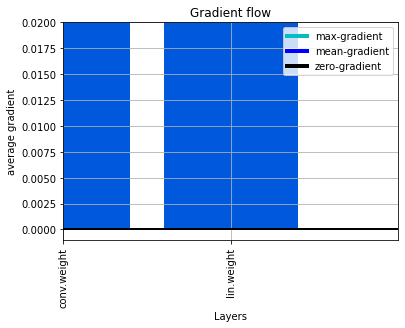

In [79]:
y = y.to(dev)
num_mini_batches = 2000 #500
M = 400
lr=5e-5
batch_size = 500 # equal to the length of the input
num_epochs = 1000
schedule = False

mi_est_values, clarity_est, x_samples, y_samples, decoder = train_model_multi(data=y, lr=lr, batch_size=batch_size, num_epochs=num_epochs, num_mini_batches=num_mini_batches,M=M, schedule=schedule)

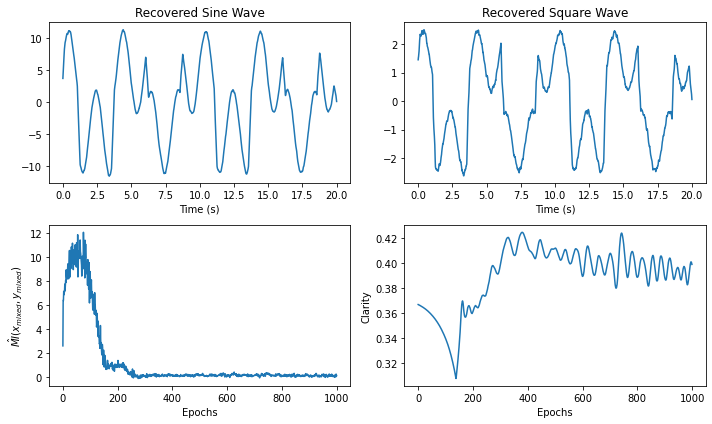

In [82]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.title('Recovered Sine Wave')
plt.plot(t, x_samples)

plt.xlabel('Time (s)')

plt.subplot(2, 2, 2)
plt.plot(t, y_samples)
plt.title('Recovered Square Wave')
plt.xlabel('Time (s)')


plt.subplot(2,2,3)
plt.plot(mi_est_values)
plt.xlabel('Epochs')
plt.ylabel('$\hat{MI}(x_{mixed}, y_{mixed})$')


plt.subplot(2,2,4)
plt.plot(clarity_est)
#plt.ylim([0, 1])
plt.xlabel('Epochs')
plt.ylabel('Clarity')
plt.tight_layout()


plt.tight_layout()
plt.savefig('recovered_components_convolution18.jpeg')

## Plotting the inverse kernels

In [74]:
for name, param in decoder.named_parameters():
    if param.requires_grad:
        print (name, param.data)

conv.weight tensor([[[-0.0280, -0.0201, -0.0350, -0.0373,  0.0552,  0.0992,  0.1041,
          -0.0354,  0.0160,  0.0991,  0.1082, -0.0271,  0.0326, -0.0264,
           0.0239,  0.0003, -0.0214,  0.0128,  0.0903,  0.0123, -0.0376,
           0.0201, -0.0432, -0.0637, -0.0394, -0.0269,  0.0562, -0.0689,
          -0.0127,  0.0726, -0.0768, -0.0866,  0.0593,  0.0983, -0.0689,
          -0.0097, -0.0337, -0.0486,  0.1092,  0.0124, -0.0702, -0.0710,
          -0.0323, -0.0582, -0.0524,  0.0208,  0.0234, -0.0748, -0.0555,
           0.0256, -0.0645,  0.0676,  0.0123,  0.0840, -0.0102,  0.0408,
           0.0215, -0.0142, -0.0753,  0.0556, -0.0314,  0.0274,  0.0528,
           0.0855, -0.0491,  0.0158, -0.0402, -0.0601,  0.0266, -0.0835,
           0.0281,  0.0294,  0.0621, -0.0185, -0.0260,  0.0421,  0.0307,
           0.1023,  0.0252,  0.0461, -0.0880, -0.0799,  0.0577, -0.0115,
          -0.0169,  0.0450,  0.0972,  0.0510, -0.0346, -0.0054,  0.0170,
          -0.0830,  0.0614, -0.0364,  0

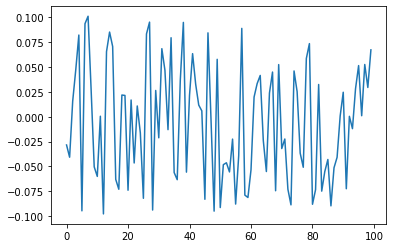

In [157]:
plt.plot([-0.0284, -0.0407,  0.0156,  0.0472,  0.0821, -0.0946,  0.0935,
           0.1010,  0.0268, -0.0504, -0.0600,  0.0005, -0.0977,  0.0654,
           0.0851,  0.0706, -0.0630, -0.0729,  0.0218,  0.0214, -0.0739,
           0.0168, -0.0465,  0.0108, -0.0162, -0.0820,  0.0832,  0.0951,
          -0.0938,  0.0264, -0.0212,  0.0684,  0.0468, -0.0130,  0.0794,
          -0.0561, -0.0633,  0.0367,  0.0948, -0.0557,  0.0215,  0.0634,
           0.0327,  0.0117,  0.0059, -0.0830,  0.0843, -0.0036, -0.0949,
           0.0577, -0.0913, -0.0482, -0.0463, -0.0555, -0.0225, -0.0878,
          -0.0392,  0.0888, -0.0788, -0.0812, -0.0534,  0.0198,  0.0333,
           0.0415, -0.0240, -0.0551,  0.0238,  0.0449, -0.0744,  0.0524,
          -0.0320, -0.0224, -0.0729, -0.0886,  0.0460,  0.0252, -0.0367,
          -0.0508,  0.0586,  0.0735, -0.0880, -0.0733,  0.0324, -0.0748,
          -0.0551, -0.0430, -0.0896, -0.0513, -0.0408,  0.0007,  0.0246,
          -0.0724,  0.0004, -0.0120,  0.0282,  0.0514,  0.0010,  0.0525,
           0.0294,  0.0672])

In [43]:
batch_size_vec = [10, 50, 100, 200]
num_mini_batches = 500
num_epochs = 500
lr_vec = [1e-5, 1e-4, 1e-3]

c = np.zeros((len(lr_vec), len(batch_size_vec)))
for i, lr in enumerate(lr_vec): 
    for j, batch_size in enumerate(batch_size_vec): 
        mi_est_values, clarity_est, x_samples, y_samples = train_model(data=y, lr=lr, batch_size=batch_size, num_epochs=num_epochs, num_mini_batches=num_mini_batches, schedule=schedule)
        c[i, j] = clarity_est[-1]
        

 76%|███████▌  | 378/500 [05:25<01:45,  1.16it/s]


# Try different decoder architechture

In [83]:
class ConvolutiveDecoder2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 =  nn.Conv1d(2, 2, kernel_size=100, groups=2, bias=False, padding='same')
        self.conv2 =  nn.Conv1d(2, 2, kernel_size=100, groups=2, bias=False, padding='same')
        #t = torch.arange(0, 100)
        #k1 = torch.flip(torch.exp(-t), dims=[-1])
        #k2 = torch.flip(torch.exp(-t), dims=[-1])
        
        
        for param in self.conv1.parameters():
            param.data = torch.ones_like(param.data) * 0.01
            
        for param in self.conv2.parameters():
            param.data = torch.ones_like(param.data) * 0.01
        
        #self.lin = nn.Linear(2, 2, bias=False)
        
    def forward(self, x_samples, y_samples):
        samples = torch.stack((x_samples, y_samples), dim=1)
        samples = samples.T.unsqueeze(0)
        
        samples_out_1 = self.conv1(samples)
        samples_out_1 = samples_out_1.squeeze(0).T
        
        samples_out_2 = self.conv2(samples)
        samples_out_2 = samples_out_2.squeeze(0).T
        
        return samples_out_1[:, 0] + samples_out_1[:, 1], samples_out_2[:, 0] + samples_out_2[:, 1]

In [84]:
def train_model_multi2(data, lr, batch_size, num_epochs, num_mini_batches, M, schedule):
    sample_dim = 1
    hidden_size = 25

    decoder = ConvolutiveDecoder2().to(dev)
    mi_estimator = CLUBSample(1, 1, hidden_size).to(dev)

    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr = lr)
    mi_optimizer = torch.optim.Adam(mi_estimator.parameters(), lr = lr)

    
    if schedule is True:
        decoder_scheduler = torch.optim.lr_scheduler.ExponentialLR(decoder_optimizer, gamma=0.999)
        mi_scheduler = torch.optim.lr_scheduler.ExponentialLR(mi_optimizer, gamma=0.999)

    mi_est_values = []
    clarity_est = []
    
    num_batches = len(data[:, 0]) // batch_size
    print('num:', num_batches)
    
    data_len = len(data[:, 0])

    
    x_samples = data[:, 0]
    y_samples = data[:, 1]
    
    x_samples = x_samples / torch.std(x_samples)
    y_samples = y_samples / torch.std(y_samples)
    for epoch in trange(num_epochs):

        random_indx = np.random.randint(num_batches, size=2)
        #random_indx = np.random.randint(data_len-batch_size, size=2)
        n = random_indx[0]
        m = random_indx[1]

        x_samples_out, y_samples_out = decoder(x_samples.float(), y_samples.float())
        x_samples_out = x_samples_out / torch.std(x_samples_out)
        y_samples_out = y_samples_out / torch.std(y_samples_out)

        x_samples_out_tmp = x_samples_out[n*batch_size : n*batch_size+batch_size]
        y_samples_out_tmp = y_samples_out[m*batch_size : m*batch_size+batch_size]
        #x_samples_out_tmp = x_samples_out[n : n + batch_size]
        #y_samples_out_tmp = y_samples_out[m : m + batch_size]

        decoder_loss = mi_estimator(x_samples_out_tmp.unsqueeze(0).T, y_samples_out_tmp.unsqueeze(0).T)
        
        for j in range(M):
            random_indx = np.random.randint(num_batches, size=2)
            #random_indx = np.random.randint(data_len-batch_size, size=2)
            n = random_indx[0]
            m = random_indx[1]
            x_samples_out_tmp = x_samples_out[n*batch_size : n*batch_size+batch_size]
            y_samples_out_tmp = y_samples_out[m*batch_size : m*batch_size+batch_size]
            #x_samples_out_tmp = x_samples_out[n : n + batch_size]
            #y_samples_out_tmp = y_samples_out[m : m + batch_size]
            decoder_loss += mi_estimator(x_samples_out_tmp.unsqueeze(0).T, y_samples_out_tmp.unsqueeze(0).T)
        
        decoder_optimizer.zero_grad()
        decoder_loss.backward(retain_graph=True)
        plot_grad_flow(decoder.named_parameters())
        decoder_optimizer.step()
        
        mi_est_values.append(decoder_loss.cpu().detach().numpy())
        
        if np.absolute(decoder_loss.cpu().detach().numpy())<1e-12 and epoch>10:
                break
        
        for i in range(num_mini_batches):
            
            random_indx = np.random.randint(num_batches, size=2)
            #random_indx = np.random.randint(data_len-batch_size, size=2)
            n = random_indx[0]
            m = random_indx[1]

            x_samples_out, y_samples_out = decoder(x_samples.float(), y_samples.float())
            x_samples_out = x_samples_out / torch.std(x_samples_out)
            y_samples_out = y_samples_out / torch.std(y_samples_out)

            x_samples_out_tmp = x_samples_out[n*batch_size : n*batch_size+batch_size]
            y_samples_out_tmp = y_samples_out[m*batch_size : m*batch_size+batch_size]
            #x_samples_out = x_samples_out[n : n + batch_size]
            #y_samples_out = y_samples_out[m : m + batch_size]

            mi_loss = mi_estimator.learning_loss(x_samples_out_tmp.unsqueeze(0).T.detach(), y_samples_out_tmp.unsqueeze(0).T.detach())
            #for j in range(M):
                #random_indx = np.random.randint(num_batches, size=2)
                #random_indx = np.random.randint(data_len-batch_size, size=2)
                #n = random_indx[0]
                #m = random_indx[1]
                #x_samples_out_tmp = x_samples_out[n*batch_size : n*batch_size+batch_size]
                #y_samples_out_tmp = y_samples_out[m*batch_size : m*batch_size+batch_size]
                #mi_loss += mi_estimator.learning_loss(x_samples_out_tmp.unsqueeze(0).T.detach(), y_samples_out_tmp.unsqueeze(0).T.detach())
            
            mi_optimizer.zero_grad()
            mi_loss.backward()
            mi_optimizer.step()
            
        if schedule is True: 
            #mi_scheduler.step()
            decoder_scheduler.step()
    
    
        x_samples, y_samples = decoder(data[:, 0].float(), data[:, 1].float())
        recovered = np.vstack((sklp.minmax_scale(x_samples.cpu().detach().numpy()), sklp.minmax_scale(y_samples.cpu().detach().numpy())))
        original = sklp.minmax_scale(inputs.T).T
        clarity_est.append(signal_clarity(original, recovered))

    return mi_est_values, clarity_est, x_samples.cpu().detach().numpy(), y_samples.cpu().detach().numpy(), decoder

In [ ]:
y = y.to(dev)
num_mini_batches = 800 #500
M = 400
lr=1e-5
batch_size = 500 # equal to the length of the input
num_epochs = 200
schedule = False

mi_est_values, clarity_est, x_samples, y_samples, decoder = train_model_multi2(data=y, lr=lr, batch_size=batch_size, num_epochs=num_epochs, num_mini_batches=num_mini_batches,M=M, schedule=schedule)

num: 20


  6%|▌         | 12/200 [00:25<06:40,  2.13s/it]

In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.title('Recovered Sine Wave')
plt.plot(t, x_samples)

plt.xlabel('Time (s)')

plt.subplot(2, 2, 2)
plt.plot(t, y_samples)
plt.title('Recovered Square Wave')
plt.xlabel('Time (s)')


plt.subplot(2,2,3)
plt.plot(mi_est_values)
plt.xlabel('Epochs')
plt.ylabel('$\hat{MI}(x_{mixed}, y_{mixed})$')


plt.subplot(2,2,4)
plt.plot(clarity_est)
#plt.ylim([0, 1])
plt.xlabel('Epochs')
plt.ylabel('Clarity')
plt.tight_layout()


plt.tight_layout()
plt.savefig('recovered_components_convolution_newdecoder.jpeg')